# Imports

In [1]:
!pip install torchbearer

     |████████████████████████████████| 138 kB 1.3 MB/s eta 0:00:01


In [2]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision import datasets

from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.color import rgb2gray

import torchbearer
import torchbearer.callbacks as callbacks
from torchbearer import Trial, state_key

from tqdm import tqdm

MU = state_key('mu')
LOGVAR = state_key('logvar')

# Data

In [27]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_folders = os.listdir(img_dir)[:30]
        self.imgs = []
        for folder in tqdm(self.img_folders):
            for img_name in os.listdir(os.path.join(img_dir, folder)):
                img = imread(os.path.join(img_dir,folder, img_name)) 
                img = img.astype('float32') / 255.
                img = np.transpose(img, (2,0,1))
                self.imgs.append(img)

    def __getitem__(self, index):
        return (self.imgs[index],self.imgs[index])

    def __len__(self):
        return len(self.imgs)
    
BATCH_SIZE = 32 
data_dir='../input/fruits/fruits-360/'

train_dataset = MyDataset(data_dir+'Training')
dataLoader_train = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_dataset = MyDataset(data_dir+'Test')
dataLoader_test = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False)

100%|██████████| 30/30 [00:41<00:00,  1.40s/it]


# Modeling

In [35]:
def beta_kl(mu_key, logvar_key, beta=5):
    @callbacks.add_to_loss
    def callback(state):
        mu = state[mu_key]
        logvar = state[logvar_key]
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * beta
    return callback

In [52]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x
    
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 1, 2),   # B,  32, 28, 28
            nn.ReLU(True),
#             PrintLayer(),
            nn.Conv2d(32, 32, 4, 2, 1),  # B,  32, 14, 14
            nn.ReLU(True),
#             PrintLayer(),
            nn.Conv2d(32, 64, 4, 2, 1),  # B,  64,  7, 7
#             PrintLayer()
        )
        
        self.mu = nn.Linear(64 * 25 * 25, latent_size)
        self.logvar = nn.Linear(64 * 25 * 25, latent_size)
        
        self.upsample = nn.Linear(latent_size, 64 * 25 * 25)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  64,  14,  14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1, 1), # B,  32, 28, 28
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 1, 2)   # B, 1, 28, 28
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, state):
        image = x
        x = self.encoder(x).relu().view(x.size(0), -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        sample = self.reparameterize(mu, logvar)
        result = self.decoder(self.upsample(sample).relu().view(-1, 64, 25, 25))
        
        if state is not None:
            state[torchbearer.Y_TRUE] = image
            state[MU] = mu
            state[LOGVAR] = logvar
        
        return result

In [54]:
model = VAE(latent_size=5)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)

trial = Trial(model, optimizer, nn.MSELoss(reduction='sum'), metrics=['acc', 'loss'],
              callbacks=[beta_kl(MU, LOGVAR), callbacks.ConsolePrinter()],
              verbose=1).with_generators(train_generator=dataLoader_train, 
                                         test_generator=dataLoader_test)

trial.run(5)
trial.evaluate(verbose=0, data_key=torchbearer.TEST_DATA)

  0%|          | 0/5 [00:00<?, ?it/s]

0/5(t): loss=53188.5625, mse=0.0531, running_loss=30865.4805, running_mse=0.0297
1/5(t): loss=26276.4297, mse=0.025, running_loss=23997.2129, running_mse=0.0226
2/5(t): loss=21612.2559, mse=0.0201, running_loss=20223.1621, running_mse=0.0186
3/5(t): loss=18957.1641, mse=0.0173, running_loss=18217.6094, running_mse=0.0165
4/5(t): loss=17458.7891, mse=0.0158, running_loss=16935.8633, running_mse=0.0152
0/1(v): test_loss=19005.3105, test_mse=0.0174


{'test_mse': 0.017357997596263885, 'test_loss': 19005.310546875}

In [55]:
torch.save(model.state_dict(), './save_vae')

# Visualization

In [102]:
class VAE_latent(nn.Module):
    def __init__(self, latent_size):
        super(VAE_latent, self).__init__()
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 1, 2),   # B,  32, 28, 28
            nn.ReLU(True),
#             PrintLayer(),
            nn.Conv2d(32, 32, 4, 2, 1),  # B,  32, 14, 14
            nn.ReLU(True),
#             PrintLayer(),
            nn.Conv2d(32, 64, 4, 2, 1),  # B,  64,  7, 7
#             PrintLayer()
        )
        
        self.mu = nn.Linear(64 * 25 * 25, latent_size)
        self.logvar = nn.Linear(64 * 25 * 25, latent_size)
        
        self.upsample = nn.Linear(latent_size, 64 * 25 * 25)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  64,  14,  14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1, 1), # B,  32, 28, 28
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 1, 2)   # B, 1, 28, 28
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        image = x
        x = self.encoder(x).relu().view(x.size(0), -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

In [103]:
vis_model = VAE_latent(latent_size=5)
vis_model.load_state_dict(torch.load('./save_vae'))

<All keys matched successfully>

In [112]:
latent_mu = pd.DataFrame()
latent_logvar = pd.DataFrame()
vis_model.eval()
with torch.no_grad():
    for step, batch in enumerate(dataLoader_train):
        mu, logvar = vis_model(batch[0])
        latent_mu = latent_mu.append(pd.DataFrame(mu.numpy()))
        latent_logvar = latent_logvar.append(pd.DataFrame(logvar.numpy()))

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

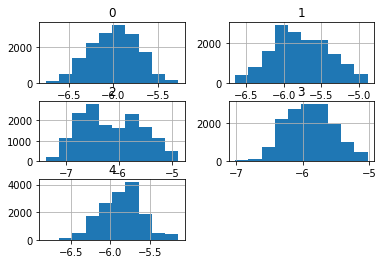

In [115]:
latent_logvar.hist()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>, <AxesSubplot:>]], dtype=object)

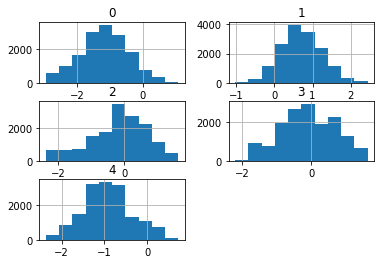

In [114]:
latent_mu.hist()

In [116]:
class Vis_VAE(nn.Module):
    def __init__(self, latent_size):
        super(Vis_VAE, self).__init__()
        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 1, 2),   # B,  32, 28, 28
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),  # B,  32, 14, 14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),  # B,  64,  7, 7
        )
        
        self.mu = nn.Linear(64 * 25 * 25, latent_size)
        self.logvar = nn.Linear(64 * 25 * 25, latent_size)
        
        self.upsample = nn.Linear(latent_size, 64 * 25 * 25)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  64,  14,  14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1, 1), # B,  32, 28, 28
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 1, 2)   # B, 1, 28, 28
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, mu, logvar):
            sample = self.reparameterize(mu, logvar)
            result = self.decoder(self.upsample(sample).relu().view(-1, 64, 25, 25))
            return result

In [117]:
vis_model = Vis_VAE(latent_size=5)
vis_model.load_state_dict(torch.load('./save_vae'))

<All keys matched successfully>

In [125]:
sample_mu = latent_mu.sample(10, random_state=42).values

In [126]:
sample_logvar = latent_logvar.sample(10, random_state=42).values

In [127]:
vis_model.eval()
with torch.no_grad():
    mu = torch.tensor(sample_mu) + torch.rand(10,5)
    log_var = torch.tensor(sample_logvar) + torch.rand(10,5)
    imgs = vis_model(mu, log_var)
imgs = np.transpose(imgs.numpy(), (0,2,3,1))

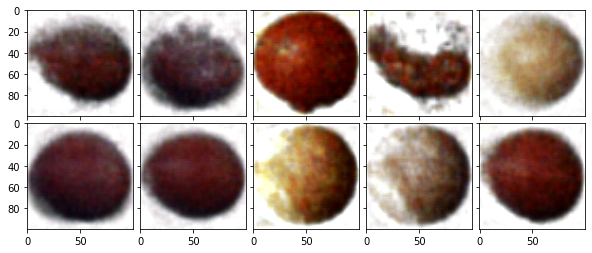

In [129]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [130]:
vis_model.eval()
with torch.no_grad():
    mu = torch.tensor(sample_mu)
    log_var = torch.tensor(sample_logvar)
    imgs = vis_model(mu, log_var)
imgs = np.transpose(imgs.numpy(), (0,2,3,1))

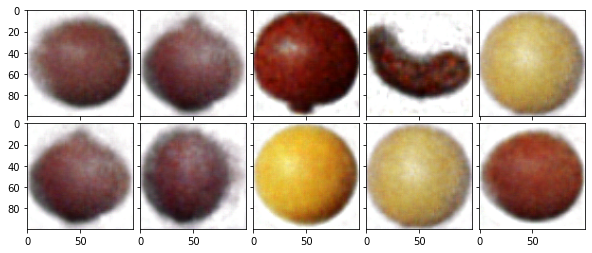

In [131]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()